#### Relax DS Challenge
Goal: Identify which factors predict future user adoption

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

path1="/Users/YingShen/Desktop/Data_Science/SpringBorad/Git/relax_challenge/takehome_user_engagement.csv"
path2="/Users/YingShen/Desktop/Data_Science/SpringBorad/Git/relax_challenge/takehome_users.csv"

# First import the summary data
df_sum = pd.read_csv(path1)
df_sum.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


__First need to identify adopted users with the definition of >=3 visits within one 7-day period__

In [22]:
# First identify users with >=3 visits 
id_counts = df_sum["user_id"].value_counts()
df_3 = df_sum[df_sum["user_id"].isin(id_counts[id_counts>2].index)]
df_3.head()

,time_stamp,user_id,visited
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1
5,2013-12-31 03:45:04,2,1


In [24]:
adopted_users = []
df_3["datetime"] = pd.to_datetime(df_3["time_stamp"])

for this_user in df_3["user_id"].unique():
    this_users_engagement = df_3[df_3["user_id"] == this_user]
    this_users_datetime = this_users_engagement["datetime"].reset_index()["datetime"]
    for i in range(len(this_users_datetime) - 2):
        time_interval = this_users_datetime[i + 2] - this_users_datetime[i]
        if time_interval <= pd.Timedelta("7 days"):
            adopted_users.append(this_user)
            break

len(adopted_users)# Finally we got the adopted user ids 

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1656

__Now deal with detailed features about users__

In [70]:
# Import the second csv file
df_users = pd.read_csv(path2,encoding='latin-1')
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [71]:
df_users.info()# there are missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


__Create target variable first__

In [76]:
def adopt_col(object_id):
    if object_id in adopted_users:
        return 1
    else:
        return 0
df_users["adopted"]=df_users["object_id"].apply(adopt_col)
df_users["adopted"].sum()# the number matches with previous counts

1656

In [77]:
df_users["adopted"].mean()# will need to oversample to adjust for minority

0.138

__Create a new variable to indicate length of use__

In [78]:
# Transfer date variables to proper format for use
import datetime
# set creation_time
df_users.creation_time = pd.to_datetime(df_users.creation_time)
#last_session_creation_time is a unix time stamp, so use map to convert to datetime
col_t = 'last_session_creation_time'
df_users[col_t] = df_users[col_t] \
     .map(lambda data: datetime.datetime.fromtimestamp(int(data)) \
     .strftime('%Y-%m-%d %H:%M:%S'),na_action='ignore')

In [86]:
# use last session date and creation date to get the length in seconds
df_users[col_t] = pd.to_datetime(df_users[col_t])
df_users['usage_length'] = df_users[col_t] - df_users['creation_time']
df_users['usage_length'] = [x.total_seconds() for x in df_users['usage_length']]
mean_seconds = df_users[df_users['usage_length']<0]["usage_length"].mean()
mean_hours = mean_s/3600
n_neg = df_users[df_users['usage_length']<0].shape[0]
print(mean_hours)
n_neg # 3027 users created their account 4 hours after their last session

-4.33168153287083


3027

__Create a new variable to indicate email provider__

In [80]:
df_users['email_provider'] = [x.split('@')[1] for x in df_users.email]
top_6 = df_users['email_provider'].value_counts().index[:6]
df_users['email_provider'] = [x if x in top_6 else 'other' for x in df_users.email_provider]
df_users['email_provider'].value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
other             1186
gustr.com         1179
hotmail.com       1165
Name: email_provider, dtype: int64

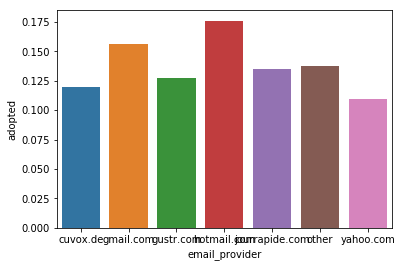

In [81]:
import seaborn as sns
def category_barplot(feature,target,df):
    f=df.groupby([feature])[target].mean()
    feature_df=pd.DataFrame(f)
    feature_df=feature_df.reset_index()
    g=sns.barplot(x=feature,y=target,data=feature_df)
    return plt.show()
category_barplot("email_provider","adopted",df_users)
# Some providers have similar adoption rates

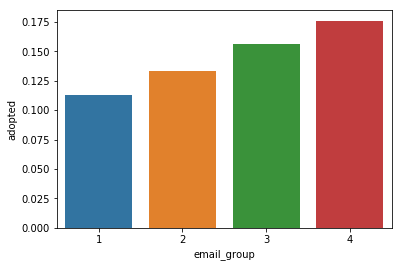

In [82]:
''' Group email providers according to their proportion of admissions '''
def email_group(provider):
    if provider in ("yahoo.com","cuvox.de"):
        return 1
    if provider in ("gustr.com","jourrapide.com","other"):
        return 2
    if provider == "gmail.com":
        return 3
    else:
        return 4
df_users['email_group']=df_users['email_provider'].apply(email_group)
category_barplot('email_group','adopted',df_users)

In [83]:
df_users["invited_by_user_id"] = df_users["invited_by_user_id"].fillna(0)

In [84]:
def invited_by_users(user_id):
    if user_id==0:
        return 0
    else:
        return 1
df_users["invited"] = df_users["invited_by_user_id"].apply(invited_by_users)
df_users["invited"].value_counts()

1    6417
0    5583
Name: invited, dtype: int64

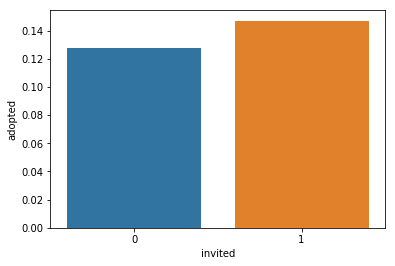

In [85]:
category_barplot('invited','adopted',df_users)
# Invited by other users encourage adoption a little

__Deal with organization ids__<br>
*Will need to group different ids based on their adoption rates*

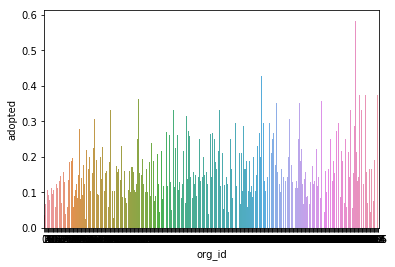

In [89]:
category_barplot('org_id','adopted',df_users)

In [97]:
# Get quantiles to set cutoff values for grouping
mean_a=df_users.groupby('org_id')["adopted"].mean()
mean_a.describe()

count    417.000000
mean       0.154903
std        0.083225
min        0.000000
25%        0.100000
50%        0.142857
75%        0.200000
max        0.583333
Name: adopted, dtype: float64

In [101]:
rank_1=[]
rank_2=[]
rank_3=[]
rank_4=[]
rank_5=[]
for i in mean_a.index:
    if mean_a[i]<=0.1:
        rank_1.append(i)
    elif 0.14>=mean_a[i]>0.1:
        rank_2.append(i)
    elif 0.2>=mean_a[i]>0.14:
        rank_3.append(i)
    elif 0.4>=mean_a[i]>0.2:
        rank_4.append(i)
    else:
        rank_5.append(i)
def org_id_group(org_id):
    if org_id in rank_1:
        return 1
    elif org_id in rank_2:
        return 2
    elif org_id in rank_3:
        return 3
    elif org_id in rank_4:
        return 4
    else:
        return 5
df_users["org_id_group"] = df_users["org_id"].apply(org_id_group)
df_users["org_id_group"].value_counts()

1    4086
2    2997
3    2964
4    1914
5      39
Name: org_id_group, dtype: int64

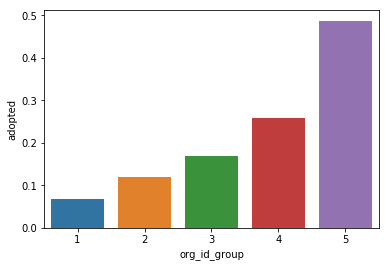

In [102]:
category_barplot('org_id_group','adopted',df_users)

In [143]:
drop_cols=["object_id","creation_time","name","email","email_provider",
           "last_session_creation_time","invited_by_user_id","org_id"]
df_temp = df_users.drop(columns=drop_cols)
df_temp.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,invited,adopted,email_group,usage_length,org_id_group
0,GUEST_INVITE,1,0,1,0,1,-14400.0,2
1,ORG_INVITE,0,0,1,1,2,11736000.0,1
2,ORG_INVITE,0,0,1,0,2,-14400.0,4
3,GUEST_INVITE,0,0,1,0,1,72000.0,1
4,GUEST_INVITE,0,0,1,0,1,414000.0,4


__Statistical Tests to Select Significant Features__

In [125]:
dummy_features=["opted_in_to_mailing_list",
                'enabled_for_marketing_drip', 
                'invited']
cat_features = ["creation_source",
                "email_group",
                "org_id_group"]
continuous_features=['usage_length']

In [126]:
from statsmodels.stats.proportion import proportions_ztest

''' Include significant dummy variables using 2-sample z test '''
significant_features=[]
for i in dummy_features:
        n_pres_readm=df_temp[df_temp[i]==1]["adopted"].sum()
        n_abs_readm=df_temp[df_temp[i]==0]["adopted"].sum()
        n_presence=len(df_temp[df_temp[i]==1])
        n_absence=len(df_temp[df_temp[i]==0])
        
        count=np.array([n_pres_readm,n_abs_readm])
        obs=np.array([n_presence, n_absence])
        stat, pval=proportions_ztest(count, obs)
        if pval<0.05:
            significant_features.append(i)
            print(i+": "+str(round(pval,3)))


invited: 0.002


In [130]:
from scipy.stats import chisquare

''' Include significant categorical variables using chi-square test '''
for i in cat_features:
    fraction=df_temp["adopted"].mean()    
    n_inclass=np.array(df_temp[i].value_counts().sort_index())
    expected=fraction*n_inclass
    
    obs=np.array(df_temp.groupby(i)['adopted'].sum().sort_index())
    
    statistics, pval=chisquare(obs, f_exp=expected)
    if pval<0.05:
        significant_features.append(i)
        print(i+": "+str(round(pval,3)))

creation_source: 0.0
email_group: 0.0
org_id_group: 0.0


In [149]:
''' Use p-values from logistic regression models '''
from statsmodels.discrete.discrete_model import Logit
mean=df_temp[continuous_features].mean()
df_temp[continuous_features]=df_temp[continuous_features].fillna(mean)
y=np.array(df['adopted']).astype(float)
X=np.array(df[continuous_features]).astype(float)

In [135]:
import statsmodels.discrete.discrete_model as sm
from scipy import stats

stats.chisqprob = lambda chisq, df_v1: stats.chi2.sf(chisq, df_v1)

logit = sm.Logit(y, X)
results=logit.fit()
params=results.params

Optimization terminated successfully.
         Current function value: 0.679780
         Iterations 2


In [136]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                12000
Model:                          Logit   Df Residuals:                    11999
Method:                           MLE   Df Model:                            0
Date:                Mon, 08 Oct 2018   Pseudo R-squ.:                 -0.6939
Time:                        21:55:13   Log-Likelihood:                -8157.4
converged:                       True   LL-Null:                       -4815.8
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1          3.059e-08    1.9e-09     16.092      0.000    2.69e-08    3.43e-08
==============================================================================
"""

In [139]:
significant_features.append('usage_length')

In [152]:
df_sig = df_temp[significant_features]

In [153]:
df_sig = pd.get_dummies(df_sig, columns = \
                    ["creation_source"], drop_first=True)

In [150]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import RandomOverSampler,SMOTE

def train_pipe(df,clf,resample=False):

    X=df.as_matrix()
    scaler = StandardScaler()
    X=scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=22)

    sampler=RandomOverSampler
    if resample==True:
        ros = sampler(ratio='auto', random_state=25)
        X_train, y_train = ros.fit_sample(X_train, y_train) 
    

    clf=clf
    clf.fit(X_train,y_train)
    scores=cross_val_score(clf, X_train, y_train, cv=5,scoring='roc_auc')
    auc_score=roc_auc_score(y_test,clf.predict(X_test))
    report=classification_report(y_test,clf.predict(X_test))
    accuracy=accuracy_score(y_test,clf.predict(X_test))
    print(report)
    return accuracy, scores, auc_score

In [154]:
''' Try RandomForest '''
from sklearn.ensemble import RandomForestClassifier

clf1=RandomForestClassifier(max_depth=6,class_weight='balanced')
display(train_pipe(df_sig,clf1))

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99      2583
        1.0       0.92      0.90      0.91       417

avg / total       0.98      0.98      0.98      3000



(0.9753333333333334,
 array([0.98973631, 0.9806675 , 0.98764601, 0.98419963, 0.98043533]),
 0.945456874918184)

#### Feature Importance

In [156]:
#make a df that displays the cofficients indexed by feature name
feature_importance = pd.DataFrame()
feature_importance['coef'] = clf1.feature_importances_
feature_importance = feature_importance.set_index(df_sig.columns)
feature_importance.coef.nlargest(10)

usage_length                          0.941753
org_id_group                          0.036779
creation_source_PERSONAL_PROJECTS     0.008917
email_group                           0.006251
creation_source_SIGNUP_GOOGLE_AUTH    0.002885
invited                               0.001654
creation_source_ORG_INVITE            0.001281
creation_source_SIGNUP                0.000480
Name: coef, dtype: float64

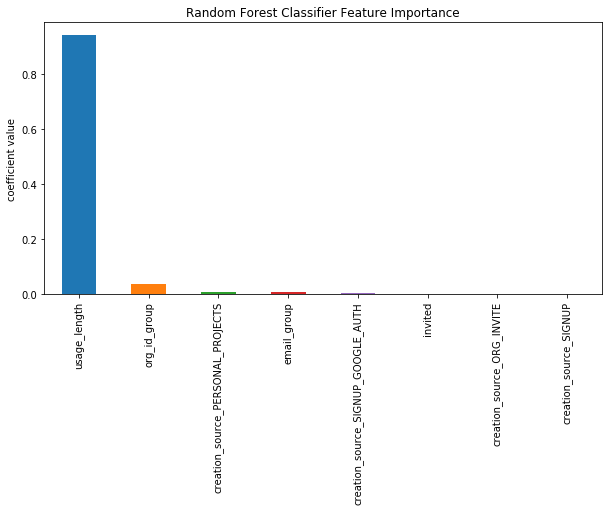

In [157]:
#plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
(feature_importance['coef']).nlargest(10).plot(kind='bar', x=feature_importance.index)
plt.title('Random Forest Classifier Feature Importance')
plt.ylabel('coefficient value')
plt.show()

#### Conclusion
Length between the count creation date and the last session date is a very strong indicator for the adoption prediction.